In [3]:
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten
from tensorflow.keras import Sequential
#from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

In [7]:
#change unix time stamp to readable
df["Date"] = pd.to_datetime(df["Timestamp"],unit="s").dt.date
df=df.groupby("Date").mean()
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Date,,,,,,,,
2011-12-31,1325346930,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,1325419170,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,1325505570,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,1325591970,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,1325678370,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


<AxesSubplot:xlabel='Date'>

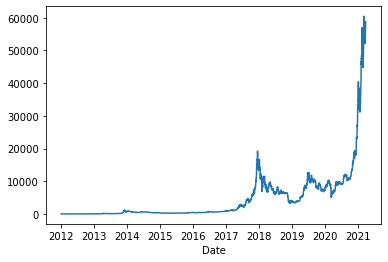

In [9]:
#rename weighted price to price, plot price over the years
price_by_date=df["Weighted_Price"].rename("Price")
price_by_date.plot()

In [20]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    print(df.head())
    print(df.isnull().sum())
    
fill_missing(btc_daily)

NameError: name 'btc_daily' is not defined

In [10]:
# Prepare timesteps groups
time_window = 15 # Time series are of (time_window - time_ahead) size
time_ahead = 1 # Short forecast
scaler=MinMaxScaler()
length = len(price_by_date)
price_scaled=scaler.fit_transform(pd.DataFrame(price_by_date))[:,-1]
price_groups = []
for i in range(0,length-time_window):
    price_groups.append(price_scaled[i:i+time_window])

price_groups = np.array(price_groups)
price_groups=price_groups[...,np.newaxis]

In [11]:
#split x and y
split_rate = 0.95
length = len(price_groups)
X_train = price_groups[:int(length*(split_rate)), :-time_ahead]
X_test =  price_groups[int(length*(split_rate)):, :-time_ahead]
y_train = price_groups[:int(length*(split_rate)),  -time_ahead:]
y_test =  price_groups[int(length*(split_rate)):,  -time_ahead:]
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3192, 14, 1) (3192, 1, 1)
(169, 14, 1) (169, 1, 1)


In [12]:
#fit model
model = keras.models.Sequential([
     keras.layers.LSTM(128,activation='relu', return_sequences=True, input_shape=(None,1)),
     keras.layers.LSTM(128,activation='relu'),
     keras.layers.Dense(time_ahead)
])

model.compile(loss='mse', optimizer="adam", metrics=['mse'])
history = model.fit(X_train, y_train, epochs=40, verbose=1,  validation_data=(X_test, y_test))

Epoch 1/40
100/100 [==============================] - 9s 48ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 2/40
100/100 [==============================] - 5s 46ms/step - loss: 8.5204e-05 - mse: 8.5204e-05 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 3/40
100/100 [==============================] - 4s 44ms/step - loss: 7.2893e-05 - mse: 7.2893e-05 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4/40
100/100 [==============================] - 4s 41ms/step - loss: 7.0399e-05 - mse: 7.0399e-05 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 5/40
100/100 [==============================] - 4s 40ms/step - loss: 7.0517e-05 - mse: 7.0517e-05 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/40
100/100 [==============================] - 5s 46ms/step - loss: 6.7297e-05 - mse: 6.7297e-05 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 7/40
100/100 [==============================] - 4s 41ms/step - loss: 4.8540e-05 - mse: 4.8540e-05 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/40
100/100 [=

In [13]:
y_pred = model.predict(X_test)[:, 0][..., np.newaxis]
y_last = price_scaled.flatten()[-time_window:]
y_pred30future=[]
for _ in range(30):
    newX = np.reshape(y_last[-time_window:],(1,time_window,1))
    y_pred30future.append(model.predict(newX)[0,0])
    y_last=np.append(y_last,np.array(y_pred30future)[-1])

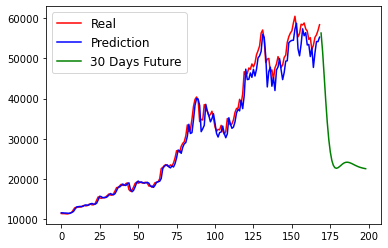

In [14]:
#Make scaled numbers normal again
y_pred_inv = scaler.inverse_transform(y_pred)
y_pred30future_inv = scaler.inverse_transform(np.reshape(y_pred30future,(len(y_pred30future),1))) 
y_test_inv = scaler.inverse_transform(y_test[:,-1])

######## Plot Real, Prediction, and 30 Days after ########
plt.plot(range(len(y_test)),y_test_inv,"r-", label="Real")
plt.plot(range(len(y_pred_inv)), y_pred_inv, "b-",label="Prediction")
plt.plot(range(len(y_pred_inv),len(y_pred_inv)+len(y_pred30future_inv)), y_pred30future_inv, "g-",label="30 Days Future")
plt.legend(fontsize=12)
plt.show()